In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
import lightgbm as lgb
import re
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("customer_credit_train.csv") #Loading the dataset

/var/folders/p7/d9_mnjys5ss5hl9mmyf2hsgr0000gn/T/ipykernel_32655/264949924.py:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("customer_credit_train.csv") #Loading the dataset


In [43]:
df.head()

,Occupation,Monthly_Inhand_Salary,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Credit_Utilization_Ratio,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,Age_Cleaned,Debt_to_Income_Ratio,Credit_History_Age_Months
0,Scientist,1824.843333,4,3,4,3,7,11.27,4,Standard,26.822620,No,49.574949,80.415295,High_spent_Small_value_payments,312.494089,Good,23,0.042376,265
1,Scientist,3093.745000,4,3,4,1,14,11.27,4,Good,31.944960,No,49.574949,118.280222,Low_spent_Large_value_payments,284.629162,Good,23,0.042376,191
2,Scientist,3093.745000,4,3,4,3,7,9.40,4,Good,28.609352,No,49.574949,81.699521,Low_spent_Medium_value_payments,331.209863,Good,33,0.042376,267
3,Scientist,3093.745000,4,3,4,5,4,6.27,4,Good,31.377862,No,49.574949,199.458074,Low_spent_Small_value_payments,223.451310,Good,23,0.042376,268
4,Scientist,1824.843333,4,3,4,6,14,11.27,4,Good,24.797347,No,49.574949,41.420153,High_spent_Medium_value_payments,341.489231,Good,23,0.042376,269


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 20 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Occupation                 100000 non-null  object 
 1   Monthly_Inhand_Salary      100000 non-null  float64
 2   Num_Credit_Card            100000 non-null  int64  
 3   Interest_Rate              100000 non-null  int64  
 4   Num_of_Loan                100000 non-null  int64  
 5   Delay_from_due_date        100000 non-null  int64  
 6   Num_of_Delayed_Payment     100000 non-null  int64  
 7   Changed_Credit_Limit       100000 non-null  float64
 8   Num_Credit_Inquiries       100000 non-null  int64  
 9   Credit_Mix                 100000 non-null  object 
 10  Credit_Utilization_Ratio   100000 non-null  float64
 11  Payment_of_Min_Amount      100000 non-null  object 
 12  Total_EMI_per_month        100000 non-null  float64
 13  Amount_invested_monthly    100

DATA PRE-PROCESSING

In [5]:
df['Delay_from_due_date'] = df['Delay_from_due_date'].abs()

In [6]:
df['Occupation'] = df['Occupation'].replace({"_______": np.nan}, regex=True)
df['Occupation'] = df['Occupation'].fillna(df['Occupation'].mode()[0])

In [7]:
df = df.drop(columns=['ID', 'Customer_ID', 'Month', 'Name', 'SSN', 'Type_of_Loan', 'Num_Bank_Accounts'], axis=1)

In [8]:
def clean_age(age_str):
    """Cleans a single age string."""
    if pd.isna(age_str):
        return np.nan  

    age_str = str(age_str).strip()  
    if age_str.startswith('-'):
        return np.nan  
    age_str = age_str.rstrip('_')

    try:
        age_int = int(age_str)
        return age_int
    except ValueError:
        return np.nan  

In [9]:
df['Age_Cleaned'] = df['Age'].apply(clean_age)

In [10]:
reasonable_max_age = 120
df['Age_Cleaned'] = df['Age_Cleaned'].apply(lambda x: x if 0 < x <= reasonable_max_age else np.nan)

In [11]:
df['Age_Cleaned'] = df['Age_Cleaned'].fillna(df['Age_Cleaned'].median())
df['Age_Cleaned'] = df['Age_Cleaned'].astype(int)

In [12]:
df['Monthly_Inhand_Salary'] = df['Monthly_Inhand_Salary'].fillna(df['Monthly_Inhand_Salary'].median())

In [13]:
df['Num_of_Delayed_Payment'] = pd.to_numeric(df['Num_of_Delayed_Payment'], errors='coerce')

In [14]:
df['Num_of_Delayed_Payment'] = df['Num_of_Delayed_Payment'].fillna(df['Num_of_Delayed_Payment'].median())
df['Num_of_Delayed_Payment'] = df['Num_of_Delayed_Payment'].astype(int)

In [15]:
df['Num_Credit_Inquiries'] = df['Num_Credit_Inquiries'].fillna(df['Num_Credit_Inquiries'].median())
df['Num_Credit_Inquiries'] = df['Num_Credit_Inquiries'].astype(int)

In [16]:
df['Credit_Mix'] = df['Credit_Mix'].replace({'_': np.nan}, regex=True)
df['Credit_Mix'] = df['Credit_Mix'].fillna(df['Credit_Mix'].mode()[0])

In [17]:
df['Annual_Income'] = pd.to_numeric(df['Annual_Income'], errors='coerce')
df['Outstanding_Debt'] = pd.to_numeric(df['Outstanding_Debt'], errors='coerce')

In [18]:
df['Debt_to_Income_Ratio'] = df['Outstanding_Debt'] / df['Annual_Income'] #Feature Engineering

In [19]:
df['Debt_to_Income_Ratio'] = df['Debt_to_Income_Ratio'].fillna(df['Debt_to_Income_Ratio'].median()) 

In [20]:
df = df.drop(columns=['Annual_Income', 'Outstanding_Debt'], axis=1)

In [21]:
df['Num_of_Loan'] = pd.to_numeric(df['Num_of_Loan'], errors='coerce')
df['Num_of_Loan'] = df['Num_of_Loan'].fillna(df['Num_of_Loan'].median())

In [22]:
df['Num_of_Loan'] = df['Num_of_Loan'].astype(int)

In [23]:
mode_credit_history = df['Credit_History_Age'].mode()[0]
df['Credit_History_Age'].fillna(mode_credit_history, inplace=True)

/var/folders/p7/d9_mnjys5ss5hl9mmyf2hsgr0000gn/T/ipykernel_32655/3684696733.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Credit_History_Age'].fillna(mode_credit_history, inplace=True)


In [24]:
def convert_to_total_months(history_str):
    if pd.isna(history_str):
        return None
    years_match = re.search(r'(\d+)\s+Year', str(history_str))
    months_match = re.search(r'(\d+)\s+Month', str(history_str))

    years = int(years_match.group(1)) if years_match else 0
    months = int(months_match.group(1)) if months_match else 0

    return float((years * 12) + months)

df['Credit_History_Age_Months'] = df['Credit_History_Age'].apply(convert_to_total_months)

In [25]:
median_credit_history_months = df['Credit_History_Age_Months'].median()
df['Credit_History_Age_Months'].fillna(median_credit_history_months, inplace=True)

/var/folders/p7/d9_mnjys5ss5hl9mmyf2hsgr0000gn/T/ipykernel_32655/3312054776.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Credit_History_Age_Months'].fillna(median_credit_history_months, inplace=True)


In [26]:
df['Payment_Behaviour'] = df['Payment_Behaviour'].replace({"!@9#%8": np.nan})
df['Payment_Behaviour'] = df['Payment_Behaviour'].fillna(df['Payment_Behaviour'].mode()[0])

In [27]:
df = df.drop_duplicates()

In [28]:
df['Changed_Credit_Limit'] = pd.to_numeric(df['Changed_Credit_Limit'], errors='coerce')
df['Changed_Credit_Limit'] = df['Changed_Credit_Limit'].fillna(df['Changed_Credit_Limit'].median())

In [29]:
df = df.drop(columns=['Credit_History_Age', 'Age'],  axis=1)

In [30]:
df['Amount_invested_monthly'] = pd.to_numeric(df['Amount_invested_monthly'], errors='coerce')
df['Monthly_Balance'] = pd.to_numeric(df['Monthly_Balance'], errors='coerce')

In [31]:
df['Amount_invested_monthly'] = df['Amount_invested_monthly'].fillna(df['Amount_invested_monthly'].median())
df['Monthly_Balance'] = df['Monthly_Balance'].fillna(df['Monthly_Balance'].median())

In [32]:
df['Credit_History_Age_Months'] = df['Credit_History_Age_Months'].astype(int)

In [33]:
reasonable_max_cc = 10
df['Num_Credit_Card'] = df['Num_Credit_Card'].apply(lambda x: x if 0 < x <= reasonable_max_cc else np.nan)

In [34]:
df['Num_Credit_Card'] = df['Num_Credit_Card'].fillna(df['Num_Credit_Card'].mode()[0])
df['Num_Credit_Card'] = df['Num_Credit_Card'].astype(int)

In [35]:
reasonable_max_loan = 10
df['Num_of_Loan'] = df['Num_of_Loan'].apply(lambda x: x if 0 < x <= reasonable_max_loan else np.nan)

In [36]:
df['Num_of_Loan'] = df['Num_of_Loan'].abs()
df['Num_of_Loan'] = df['Num_of_Loan'].fillna(df['Num_of_Loan'].mode()[0])

In [37]:
df['Payment_of_Min_Amount'] = df['Payment_of_Min_Amount'].replace({"NM": np.nan})
df['Payment_of_Min_Amount'] = df['Payment_of_Min_Amount'].fillna(df['Payment_of_Min_Amount'].mode()[0])

In [38]:
df['Num_of_Loan'] = df['Num_of_Loan'].astype(int)

In [39]:
reasonable_max_interest = 20
df['Interest_Rate'] = df['Interest_Rate'].apply(lambda x: x if 0 < x <= reasonable_max_interest else np.nan)

In [40]:
df['Interest_Rate'] = df['Interest_Rate'].fillna(df['Interest_Rate'].mode()[0])
df['Interest_Rate'] = df['Interest_Rate'].astype(int)

In [41]:
df['Num_of_Delayed_Payment'] = df['Num_of_Delayed_Payment'].abs()

In [42]:
df['Credit_Score'].value_counts(normalize=True) #Check if the target is imbalanced 

Credit_Score
Standard    0.53174
Poor        0.28998
Good        0.17828
Name: proportion, dtype: float64

In [49]:
X = df.drop(columns='Credit_Score', axis=1)
y = df['Credit_Score'] #Splitting into target and features

In [50]:
le = LabelEncoder()
for col in ['Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour', 'Credit_Score', 'Occupation']:
    if col in df.columns:
        df[col] = le.fit_transform(df[col]) #Encoding the categorical columns

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

In [52]:
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train) #Working on the imbalanced target

In [53]:
y_train_smote.value_counts(normalize=True) #The target has been balanced

Credit_Score
2    0.333333
1    0.333333
0    0.333333
Name: proportion, dtype: float64

MODEL TRAINING AND BUILDING

In [54]:
pipeline = Pipeline([
    ('ss', StandardScaler()),
    ('rfc', RandomForestClassifier())
])

In [55]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=30)

In [56]:
params = {
    'rfc__n_estimators': range(10, 100, 20),
    'rfc__max_depth': range(10, 100, 25)
}

In [57]:
#Hyper-parameter tuning
model = GridSearchCV(
    pipeline,
    param_grid = params,
    cv = cv,
    n_jobs = 5,
    verbose = 1
)

In [58]:
model.fit(X_train_smote, y_train_smote) #Training a Random Forest Classifier

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=30, shuffle=True),
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('rfc', RandomForestClassifier())]),
             n_jobs=5,
             param_grid={'rfc__max_depth': range(10, 100, 25),
                         'rfc__n_estimators': range(10, 100, 20)},
             verbose=1)

In [59]:
model.score(X_train_smote, y_train_smote)

0.9996944914457605

In [60]:
y_pred = model.predict(X_test)

In [61]:
print(classification_report(y_test, y_pred)) #Evaluation Metrics

              precision    recall  f1-score   support

           0       0.61      0.78      0.68      3590
           1       0.74      0.79      0.77      5788
           2       0.82      0.72      0.77     10622

    accuracy                           0.75     20000
   macro avg       0.73      0.76      0.74     20000
weighted avg       0.76      0.75      0.75     20000



In [62]:
pipeline2 = Pipeline([
    ('ss', StandardScaler()),
    ('lr', LogisticRegression())
])

In [63]:
params2 = {
    'lr__penalty': ['l2'],
    'lr__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'lr__solver': ['lbfgs'],
    'lr__tol': [1e-4],
    'lr__fit_intercept': [True],
    'lr__class_weight': ['balanced']
}

In [64]:
model2 = GridSearchCV(
    pipeline2,
    param_grid=params2,
    cv=cv,
    n_jobs=5,
    verbose=1
)

In [65]:
model2.fit(X_train_smote, y_train_smote) #Training a Logistic Regression Model

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=30, shuffle=True),
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('lr', LogisticRegression())]),
             n_jobs=5,
             param_grid={'lr__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'lr__class_weight': ['balanced'],
                         'lr__fit_intercept': [True], 'lr__penalty': ['l2'],
                         'lr__solver': ['lbfgs'], 'lr__tol': [0.0001]},
             verbose=1)

In [66]:
model2.score(X_train_smote, y_train_smote)

0.6826157799085041

In [67]:
y_pred2 = model2.predict(X_test)

In [68]:
print(classification_report(y_test, y_pred2))    #Evaluation Metrics

              precision    recall  f1-score   support

           0       0.48      0.73      0.57      3590
           1       0.60      0.59      0.59      5788
           2       0.72      0.59      0.65     10622

    accuracy                           0.62     20000
   macro avg       0.60      0.64      0.61     20000
weighted avg       0.64      0.62      0.62     20000



In [69]:
pipeline3 = Pipeline([
    ('ss', StandardScaler()),
    ('dtc', DecisionTreeClassifier())
])

In [70]:
params3 = {
    "dtc__max_depth": range(25, 100, 25),
    "dtc__min_samples_split": range(25, 100, 30),
    "dtc__min_samples_leaf": range(25, 100, 30)
}

In [71]:
model3 = GridSearchCV(
    pipeline3,
    param_grid=params3,
    cv=cv,
    n_jobs=5,
    verbose=1
)

In [72]:
model3.fit(X_train_smote, y_train_smote) #Training a Decision Tree Classifier Model

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=30, shuffle=True),
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('dtc', DecisionTreeClassifier())]),
             n_jobs=5,
             param_grid={'dtc__max_depth': range(25, 100, 25),
                         'dtc__min_samples_leaf': range(25, 100, 30),
                         'dtc__min_samples_split': range(25, 100, 30)},
             verbose=1)

In [73]:
model3.score(X_train_smote, y_train_smote)

0.7907031396879113

In [74]:
y_pred3 = model3.predict(X_test)

In [75]:
print(classification_report(y_test, y_pred3)) 

              precision    recall  f1-score   support

           0       0.53      0.68      0.59      3590
           1       0.65      0.72      0.68      5788
           2       0.77      0.65      0.70     10622

    accuracy                           0.68     20000
   macro avg       0.65      0.68      0.66     20000
weighted avg       0.69      0.68      0.68     20000



In [76]:
pipeline4 = Pipeline([
    ('ss', StandardScaler()),
    ('xgb', XGBClassifier(random_state=30))
])

In [77]:
params4 = {
    "xgb__max_depth": [3, 5, 7, 10, 25],
    "xgb__n_estimators": [50, 100, 150, 200],
    "xgb__learning_rate": [0.01, 0.05, 0.1, 0.2],
    "xgb__subsample": [0.7, 0.8, 0.9],
    "xgb__colsample_bytree": [0.6, 0.7, 0.8],
    "xgb__gamma": [0, 0.1, 0.2]
}

In [78]:
#Hyper Paramameter Tuning
model4 = RandomizedSearchCV(
    pipeline4,
    param_distributions=params4,
    n_iter=100,
    scoring='accuracy',
    cv=cv,
    n_jobs=5,
    verbose=1
)

In [79]:
model4.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=30, shuffle=True),
                   estimator=Pipeline(steps=[('ss', StandardScaler()),
                                             ('xgb',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            device=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_metric=None,
                                                            feature_...
                                                            multi_strategy=None,
                                                            n_estimators=None,
                                                            n_jobs=None,
                                                            num_parallel_tree=None, ...))]),
                   n_iter=100, n_jobs=5,
                   param_distributions={'xgb__colsample_bytree': [0.6, 0.7,
                                                                  0.8],
                                        'xgb__gamma': [0, 0.1, 0.2],
                                        'xgb__learning_rate': [0.01, 0.05, 0.1,
                                                               0.2],
                                        'xgb__max_depth': [3, 5, 7, 10, 25],
                                        'xgb__n_estimators': [50, 100, 150,
                                                              200],
                                        'xgb__subsample': [0.7, 0.8, 0.9]},
                   scoring='accuracy', verbose=1)

In [80]:
model4.score(X_train_smote, y_train_smote)

1.0

In [81]:
y_pred4 = model4.predict(X_test)

In [82]:
print(classification_report(y_test, y_pred4)) #Evaluation Metrics

              precision    recall  f1-score   support

           0       0.67      0.76      0.71      3590
           1       0.76      0.80      0.78      5788
           2       0.82      0.76      0.79     10622

    accuracy                           0.77     20000
   macro avg       0.75      0.77      0.76     20000
weighted avg       0.77      0.77      0.77     20000



EVALUATION

In [83]:
cm = confusion_matrix(y_test, y_pred4)

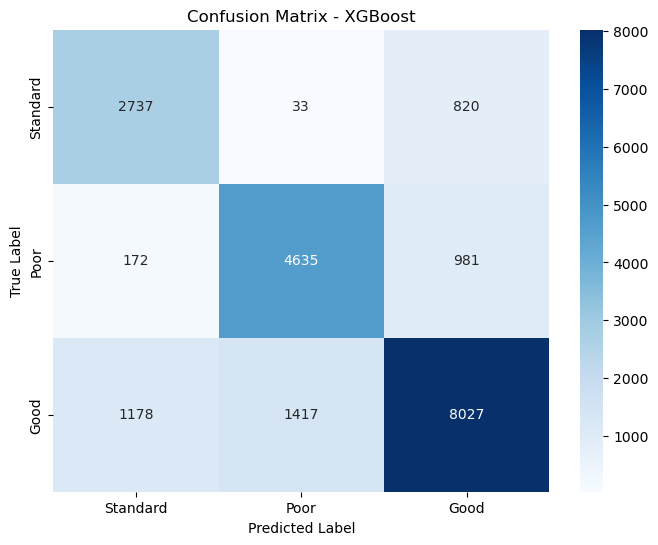

In [84]:
#Code For Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Standard', 'Poor', 'Good'],  
            yticklabels=['Standard', 'Poor', 'Good'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - XGBoost') 
plt.show() 

In [85]:
best_xgb_model = model4.best_estimator_

In [86]:
xgb_estimator = best_xgb_model.named_steps['xgb']
importances = xgb_estimator.feature_importances_
feature_names = X_train_smote.columns
feat_importance = pd.Series(importances, index=feature_names).sort_values() 

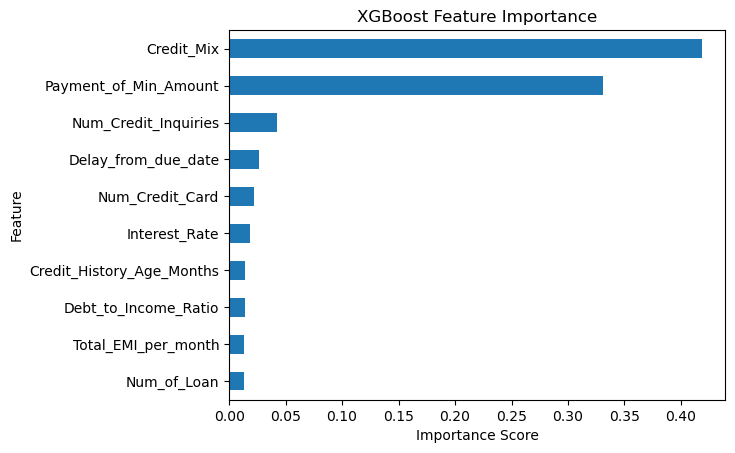

In [87]:
#Plotting The Feature Importance
feat_importance.tail(10).plot(kind='barh')
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("XGBoost Feature Importance")
plt.show()

SAVING THE MODELS

In [88]:
import joblib

In [89]:
joblib.dump(best_xgb_model, "credit_classification_xgb.pkl") #Saving the XGB CLassifier model

['credit_classification_xgb.pkl']

In [90]:
joblib.dump(le, "credit_classification_le.pkl")

['credit_classification_le.pkl']

In [6]:
df['Occupation'].unique()

array(['Scientist', 'Null', 'Teacher', 'Engineer', 'Entrepreneur',
       'Developer', 'Lawyer', 'Media_Manager', 'Doctor', 'Journalist',
       'Manager', 'Accountant', 'Musician', 'Mechanic', 'Writer',
       'Architect'], dtype=object)

In [45]:
df['Payment_of_Min_Amount'].unique()

array(['No', 'Yes'], dtype=object)

In [46]:
df['Payment_Behaviour'].unique()

array(['High_spent_Small_value_payments',
       'Low_spent_Large_value_payments',
       'Low_spent_Medium_value_payments',
       'Low_spent_Small_value_payments',
       'High_spent_Medium_value_payments',
       'High_spent_Large_value_payments'], dtype=object)

In [47]:
df['Credit_Mix'].unique()

array(['Standard', 'Good', 'Bad'], dtype=object)

In [46]:
print(df['Monthly_Inhand_Salary'].min())
print(df['Monthly_Inhand_Salary'].max())

303.6454166666666
15204.633333333331


In [47]:
print(df['Monthly_Inhand_Salary'].min())
print(df['Monthly_Inhand_Salary'].max())

303.6454166666666
15204.633333333331


In [48]:
print(df['Monthly_Inhand_Salary'].min())
print(df['Monthly_Inhand_Salary'].max())

303.6454166666666
15204.633333333331


In [49]:
print(df['Monthly_Inhand_Salary'].min())
print(df['Monthly_Inhand_Salary'].max())

303.6454166666666
15204.633333333331


In [121]:
df['Credit_History_Age_Months'].min()

1

In [123]:
df.head(10)

,Occupation,Monthly_Inhand_Salary,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Credit_Utilization_Ratio,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,Age_Cleaned,Debt_to_Income_Ratio,Credit_History_Age_Months
0,12,1824.843333,4,3,4,3,7,11.27,4,2,26.822620,0,49.574949,80.415295,2,312.494089,0,23,0.042376,265
1,12,3093.745000,4,3,4,1,14,11.27,4,1,31.944960,0,49.574949,118.280222,3,284.629162,0,23,0.042376,191
2,12,3093.745000,4,3,4,3,7,9.40,4,1,28.609352,0,49.574949,81.699521,4,331.209863,0,33,0.042376,267
3,12,3093.745000,4,3,4,5,4,6.27,4,1,31.377862,0,49.574949,199.458074,5,223.451310,0,23,0.042376,268
4,12,1824.843333,4,3,4,6,14,11.27,4,1,24.797347,0,49.574949,41.420153,1,341.489231,0,23,0.042376,269
5,12,3093.745000,4,3,4,8,4,9.27,4,1,27.262259,0,49.574949,62.430172,5,340.479212,0,23,0.042376,270
6,12,1824.843333,4,3,4,3,14,11.27,4,1,22.537593,0,49.574949,178.344067,5,244.565317,0,23,0.042376,271
7,12,1824.843333,4,3,4,3,6,11.27,4,1,23.933795,0,49.574949,24.785217,1,358.124168,2,23,0.042376,191
8,7,3037.986667,4,6,1,3,4,5.42,2,1,24.464031,0,18.816215,104.291825,5,470.690627,2,28,0.017362,319
9,13,3037.986667,4,6,1,7,1,7.42,2,1,38.550848,0,18.816215,40.391238,0,484.591214,0,28,0.017362,320
